# Twitter sentiment analysis V0 - baseline model
- Features created: None
- Model : LSTM
- External preprocessing : GloVe word embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from keras.models import Sequential

from keras.layers import LSTM,Dense,Dropout,Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
os.chdir("/content/drive/My Drive/Colab Notebooks/TwitterSentimentAnalysis/")
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/TwitterSentimentAnalysis'

In [ ]:
train = pd.read_csv("train_E6oV3lV.csv")
test = pd.read_csv("test_tweets_anuFYb8.csv")


In [ ]:
x = train['tweet']
y = train['label']
token  = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)
pad_seq = pad_sequences(seq, maxlen=300)
vocab_size = len(token.word_index) + 1
embedding_vector = np.load("glove.840B.300d.pkl", allow_pickle=True)

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(token.word_index.items()):
  embedding_value = embedding_vector.get(word)
  if embedding_value is not None:
    embedding_matrix[i] = embedding_value

100%|██████████| 45889/45889 [00:00<00:00, 591716.67it/s]


In [ ]:
train_lim = int(len(embedding_matrix) * 0.95)
train_matrix = embedding_matrix[:train_lim]
test_matrix = embedding_matrix[train_lim:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Embedding,Bidirectional

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
?model.compile

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=300,trainable = False))
model.add(Bidirectional(LSTM(75)))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = [f1,'accuracy'])
history = model.fit(pad_seq,y,epochs = 20,batch_size=64,validation_split=0.2)

Epoch 1/20
400/400 [==============================] - 19s 41ms/step - loss: 0.2154 - f1: 0.2622 - accuracy: 0.9304 - val_loss: 0.1297 - val_f1: 0.4968 - val_accuracy: 0.9498
Epoch 2/20
400/400 [==============================] - 15s 38ms/step - loss: 0.1168 - f1: 0.6130 - accuracy: 0.9570 - val_loss: 0.1201 - val_f1: 0.5777 - val_accuracy: 0.9556
Epoch 3/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0950 - f1: 0.6912 - accuracy: 0.9664 - val_loss: 0.1186 - val_f1: 0.5943 - val_accuracy: 0.9567
Epoch 4/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0791 - f1: 0.7450 - accuracy: 0.9715 - val_loss: 0.1137 - val_f1: 0.5913 - val_accuracy: 0.9592
Epoch 5/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0617 - f1: 0.7895 - accuracy: 0.9781 - val_loss: 0.1181 - val_f1: 0.6328 - val_accuracy: 0.9595
Epoch 6/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0427 - f1: 0.8780 - accuracy: 0.9858 - val_loss: 0.1

In [ ]:
testing = pd.read_csv('sample_submission_gfvA5FD.csv')
testing.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [ ]:
x_test = test['tweet']
x_test = token.texts_to_sequences(x_test)
testing_seq = pad_sequences(x_test, maxlen=300)
predict = np.round(model.predict(testing_seq)).astype('int')
testing['label'] = predict
testing.label.value_counts()

0    16183
1     1014
Name: label, dtype: int64

In [ ]:
testing.to_csv("submission_out.csv",index=False)

# Twitter sentiment analysis V1 - feature engineering
- Features created: None
- Model : LSTM
- External preprocessing : GloVe word embedding

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from keras.models import Sequential

from keras.layers import LSTM,Dense,Dropout,Embedding,Bidirectional, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
os.chdir("/content/drive/My Drive/Colab Notebooks/TwitterSentimentAnalysis/")
os.getcwd()

train = pd.read_csv("train_E6oV3lV.csv")
test = pd.read_csv("test_tweets_anuFYb8.csv")


In [3]:

import pandas as pd
import numpy as np
import string
import re
import gc
from collections import defaultdict
from wordcloud import STOPWORDS


class FeatureCreation:


  """Takes pandas dataframe and text column name and returns a pandas dataframe 
  with additional word based columns
  ...

  Attributes
  -----------
  dataset: pandas dataframe input
  textcol: feature name string

  Methods
  -----------
  get_features()
    returns dataframe with 9 word based features

  """


  def __init__(self, dataset: pd.DataFrame, textcol: str):
      self.dataset = dataset
      self.textcol = textcol

  def get_features(self):
      df_var = self.dataset
      # word count
      text_col = self.textcol
      df_var['word_count'] = df_var[text_col].apply(lambda x: len(str(x).split()))
      # get unique words
      df_var['unique_word_count'] = df_var[text_col].apply(
          lambda x: len(set(str(x).split())))
      # get stop words
      df_var['stop_word_count'] = df_var[text_col].apply(
          lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS
            ]))
      df_var['url_count'] = df_var[text_col].apply(
          lambda x: len([w for w in str(x).lower().split() if "http" in w or "https" in w]))
      df_var['mean_word_length'] = df_var[text_col].apply(
          lambda x: np.mean([len(w) for w in str(x).split()]))
      df_var['char_count'] = df_var[text_col].apply(lambda x: len(str(x)))
      df_var['punctuation_count'] = df_var[text_col].apply(
          lambda x: len([w for w in str(x) if w in string.punctuation]))
      df_var['hashtag_count'] = df_var[text_col].apply(
          lambda x: len([w for w in str(x) if w == "#"]))
      df_var['mention_count'] = df_var[text_col].apply(
          lambda x: len([w for w in str(x) if w == "@"]))

      return df_var

  def remove_specials(self):
    #pattern = re.compile('[\W_]+')
    dfcleantext = self.dataset
    text_col = self.textcol
    dfcleantext[text_col] = dfcleantext[text_col].apply(
        lambda x: re.sub(r'([^\s\w]|_)+', '', x))
    return dfcleantext
      

from tensorflow.keras import backend as K
import tensorflow as tf
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [4]:
train_obj = FeatureCreation(train,'tweet')
train_features = train_obj.get_features()
#train_obj = FeatureCreation(train_features,'tweet')
#train_features = train_obj.remove_specials()
train_features.head()

,id,label,tweet,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,0,@user when a father is dysfunctional and is s...,18,16,10,0,4.555556,102,3,1,1
1,2,0,@user @user thanks for #lyft credit i can't us...,19,18,6,0,5.315789,122,8,3,2
2,3,0,bihday your majesty,3,3,1,0,5.666667,21,0,0,0
3,4,0,#model i love u take with u all the time in ...,14,13,5,0,4.928571,86,4,1,0
4,5,0,factsguide: society now #motivation,4,4,0,0,8.000000,39,2,1,0


In [5]:
test_obj = FeatureCreation(test,'tweet')
test_features = test_obj.get_features()
#test_obj = FeatureCreation(test_features,'tweet')
#test_features = test_obj.remove_specials()
test_features.head()

,id,tweet,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,31963,#studiolife #aislife #requires #passion #dedic...,9,9,1,0,8.777778,90,7,7,0
1,31964,@user #white #supremacists want everyone to s...,16,16,4,0,5.125000,101,5,4,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,9,9,2,0,6.333333,71,8,4,0
3,31966,is the hp and the cursed child book up for res...,22,20,8,0,5.409091,142,8,3,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",15,15,4,0,5.066667,93,4,2,0


In [6]:
x = train_features['tweet']
y = train_features['label']
token  = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)
pad_seq = pad_sequences(seq, maxlen=300)
vocab_size = len(token.word_index) + 1

In [7]:
embedding_vector = np.load("glove.840B.300d.pkl", allow_pickle=True)

embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(token.word_index.items()):
  embedding_value = embedding_vector.get(word)
  if embedding_value is not None:
    embedding_matrix[i] = embedding_value

100%|██████████| 45889/45889 [00:00<00:00, 514765.64it/s]


In [8]:
# Make our meta features usable for deep learning along with the text data in LSTM
meta_features = ['word_count', 'unique_word_count',
       'stop_word_count', 'url_count', 'mean_word_length', 'char_count',
       'punctuation_count', 'hashtag_count', 'mention_count']
train_meta = train_features[meta_features].values
test_meta = test_features[meta_features].values


In [9]:
from sklearn.preprocessing import normalize

train_meta = normalize(train_meta, norm='max')


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6)]
model = Sequential()
model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=300,trainable = False))
model.add(Dense(32,activation = 'relu'))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(16,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = [f1,'accuracy'])
history = model.fit(pad_seq,y,epochs = 16,batch_size=64,validation_split=0.2, callbacks=my_callbacks)

In [73]:
embedding_matrix.shape

(45890, 300)

In [141]:
# create functional deep learning layers instead of Sequential
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.regularizers import l1
input_1 = Input(shape=(300,))
input_2 = Input(shape=(9,))

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(64, dropout=0.4)(embedding_layer)

dense_layer_1 = Dense(32, activation='relu', bias_regularizer=l1(0.005))(input_2)
dense_layer_2 = Dense(32, activation='relu', bias_regularizer=l1(0.005))(dense_layer_1)

concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(16, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
print(model.summary())

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 300, 300)     13767000    input_107[0][0]                  
__________________________________________________________________________________________________
dense_172 (Dense)               (None, 32)           320         input_108[0][0]                  
___________________________________________________________________________________________

In [142]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6)]
history = model.fit(x=[pad_seq, train_meta], y=y, batch_size=512, epochs=30, verbose=1, validation_split=0.2,callbacks=my_callbacks)

Epoch 1/30
50/50 [==============================] - 7s 110ms/step - loss: 0.4057 - accuracy: 0.8932 - f1: 0.0229 - val_loss: 0.1838 - val_accuracy: 0.9356 - val_f1: 0.1443
Epoch 2/30
50/50 [==============================] - 5s 100ms/step - loss: 0.1755 - accuracy: 0.9354 - f1: 0.2579 - val_loss: 0.1466 - val_accuracy: 0.9402 - val_f1: 0.3972
Epoch 3/30
50/50 [==============================] - 5s 99ms/step - loss: 0.1532 - accuracy: 0.9408 - f1: 0.4603 - val_loss: 0.1335 - val_accuracy: 0.9493 - val_f1: 0.5302
Epoch 4/30
50/50 [==============================] - 5s 100ms/step - loss: 0.1378 - accuracy: 0.9500 - f1: 0.5702 - val_loss: 0.1338 - val_accuracy: 0.9514 - val_f1: 0.5345
Epoch 5/30
50/50 [==============================] - 5s 99ms/step - loss: 0.1325 - accuracy: 0.9522 - f1: 0.5873 - val_loss: 0.1285 - val_accuracy: 0.9521 - val_f1: 0.5911
Epoch 6/30
50/50 [==============================] - 5s 100ms/step - loss: 0.1253 - accuracy: 0.9556 - f1: 0.6158 - val_loss: 0.1232 - val_accu

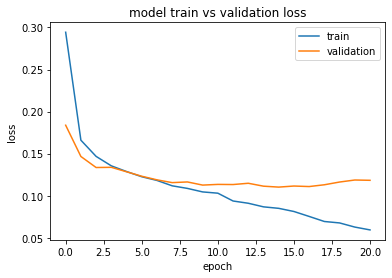

In [143]:
from matplotlib import pyplot
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [144]:

testing = pd.read_csv('sample_submission_gfvA5FD.csv')
x_test = test['tweet']
x_test = token.texts_to_sequences(x_test)
testing_seq = pad_sequences(x_test, maxlen=300)
test_meta = normalize(test_meta, norm='max', axis=0)
predict = np.round(model.predict([testing_seq,test_meta])).astype('int')
testing['label'] = predict
testing.label.value_counts()

0    16025
1     1172
Name: label, dtype: int64

In [145]:
testing.to_csv("submission_out_v6.csv",index=False)

In [ ]:
embedding_matrix.shape

In [ ]:
train_features.shape